## Setup
Below we import modules we use in this assignment.

In [1]:
import torch
from torch import nn 
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

## Loading Dataset
Below we load the MNIST dataset normalized.

In [3]:
data_mean = [0.1307]
data_std = [0.3081]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std)])


trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

loss_fn = torch.nn.CrossEntropyLoss()

dm = torch.as_tensor(data_mean, device=device)[:, None, None]
ds = torch.as_tensor(data_std, device=device)[:, None, None]

def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu())
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu())

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




17.9%

100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100.0%


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Simple Fully Connected Neural Network
Here, we define a simple fully connected neural network with ReLU activation and we randomly initialize it 

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

act = nn.ReLU

model = nn.Sequential(
    Flatten(),
    nn.Linear(784, 500),
    act(),
    nn.Linear(500, 500),
    act(),
    nn.Linear(500, 500),
    act(),
    nn.Linear(500, 500),
    act(),
    nn.Linear(500,10)
).to(device)

model.apply(weights_init)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=500, bias=True)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=500, bias=True)
  (4): ReLU()
  (5): Linear(in_features=500, out_features=500, bias=True)
  (6): ReLU()
  (7): Linear(in_features=500, out_features=500, bias=True)
  (8): ReLU()
  (9): Linear(in_features=500, out_features=10, bias=True)
)

## Original Image
Next, we load the first image of the dataset. Think of it as the first image on which the first client will compute an update

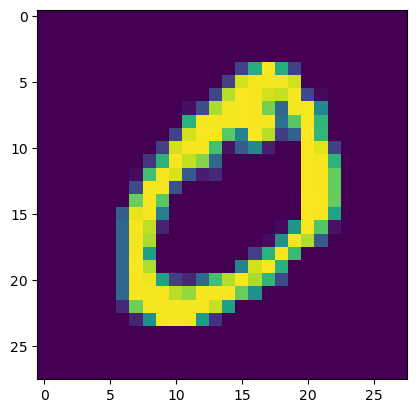

In [8]:
idx=1
img, label = trainset[idx]
ground_truth_label = torch.as_tensor([label], device=device)
ground_truth_img = img.to(device).unsqueeze(0)
plot(ground_truth_img)

## Federated Gradient 
Next, we compute the gradient send by this client to the server. 

In [6]:
target_loss = loss_fn(model(ground_truth_img), ground_truth_label)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

## Gradient Inversion
Next, we invert the original image from input_gradient. Note we do not invert the label here for simplicity. This is usually done in a separate preprocessing step based on analytical methods. Complete the code of the inversion with the L2 gradient reconstruction loss weighted by the supplied layer_weights. Use total variation as image prior. Initialize the image uniformly on [-0.5,0.5]. 

In [7]:
def closure(optimizer, net, loss_fn, gt_img, x_reconstruct, gt_grad, gt_label, it, log):
    def reconstuct_loss():
        optimizer.zero_grad()
        net.zero_grad()
        loss = loss_fn(model(x_reconstruct), ground_truth_label)
        reconstruct_gradient = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        rec_loss = torch.as_tensor([0.0], device=device)

        layer_weights = torch.arange(len(input_gradient), 0, -1, dtype=x_reconstruct.dtype, device=device)
        layer_weights = layer_weights.softmax(dim=0)
        layer_weights = layer_weights / layer_weights[0] # Apply layer weights to reconstruction error

        for rec_g, in_g, w in zip(reconstruct_gradient, gt_grad, layer_weights):
            rec_loss += ((rec_g - in_g)*w).pow(2).mean()

        tv_x = (x_reconstruct[:,:,1:,:] - x_reconstruct[:,:,:-1,:]).abs().mean()
        tv_y = (x_reconstruct[:,:,:,1:] - x_reconstruct[:,:,:,:-1]).abs().mean()
        tv = tv_x + tv_y
        final_loss = rec_loss + 1e-4 * tv
        final_loss.backward()
        x_reconstruct.grad.sign_()
        if log:
            print( 'It:', it, 'Error:', (ground_truth_img - x_reconstruct).pow(2).mean().item(),
                   'TV:', tv.item(), 'Reconstr:', rec_loss.item())

        return rec_loss
    return reconstuct_loss
    
def invert_grad(net, loss_fn, gt_img, gt_label, gt_grad):
    x_reconstruct = (torch.rand(gt_img.shape, device=device)  - 0.5) * 2
    x_reconstruct.requires_grad = True

    max_iterations = 1000
    optimizer = torch.optim.Adam([x_reconstruct], lr=0.06)

    for it in range(max_iterations):
        reconstuct_loss = closure(optimizer, net, loss_fn, gt_img, x_reconstruct, gt_grad, gt_label, it, it % 100 == 0)
        rec_loss = optimizer.step(reconstuct_loss)

    return x_reconstruct

It: 0 Error: 1.475324034690857 TV: 1.3362493515014648 Reconstr: 1119.5107421875
It: 100 Error: 0.00048553533270023763 TV: 0.5505000948905945 Reconstr: 15.38479995727539
It: 200 Error: 0.00024532765382900834 TV: 0.5451605916023254 Reconstr: 14.100913047790527
It: 300 Error: 0.00040568021358922124 TV: 0.5438416600227356 Reconstr: 19.373104095458984
It: 400 Error: 0.00038194761145859957 TV: 0.5500332117080688 Reconstr: 21.302085876464844
It: 500 Error: 0.00025684278807602823 TV: 0.5426187515258789 Reconstr: 12.485601425170898
It: 600 Error: 0.0003187524853274226 TV: 0.5477410554885864 Reconstr: 28.744462966918945
It: 700 Error: 0.00075688143260777 TV: 0.5630650520324707 Reconstr: 33.067138671875
It: 800 Error: 0.0005283703794702888 TV: 0.5609391927719116 Reconstr: 19.037981033325195
It: 900 Error: 0.00032060322700999677 TV: 0.5528668761253357 Reconstr: 12.967889785766602


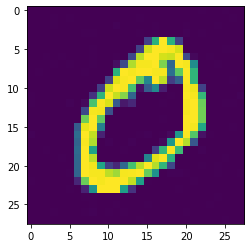

In [8]:
plot(invert_grad(model, loss_fn, ground_truth_img, ground_truth_label, input_gradient))
